# Calculate Correlation Coefficients for Extended Family Members:

+ Calculate for cells in Gen #1-6
+ Only include cells with cell cycle duration of <7.0, 42.0>

**Studies that report correlation coefficients:**
+ [Kuchen et al., 2020](https://elifesciences.org/articles/51002 "Hidden long-range memories of growth and cycle speed correlate cell cycles in lineage trees") - TET21N neuroblastoma cells
+ [Chakrabarti et al., 2018](https://www.nature.com/articles/s41467-018-07788-5 "Hidden heterogeneity and circadian-controlled cell fate inferred from single cell lineages") - HCT116 human colorectal cancer cells
+ [Sandler et al., 2015](https://www.nature.com/articles/nature14318 "Lineage correlations of single cell division time as a probe of cell-cycle dynamics") - L1210 lymphoblast cells


In [36]:
import h5py
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from Find_Family_Members import Find_Family


In [14]:
hdf5_file = "../example_segment_classif_tracked_movie.hdf5"


## Define the types of kinships (family relationships) which you intent to analyse:

The depth & breadth of our **automatically reconstructed lineage trees** allows you to look as far as to 5 generations upstream of the reference cell:

In [15]:
names = ["mother", "sister", 
         "grandmother", 'aunt', "1st cousins", 
         "1x great-grandmother", "grandaunt", "1st cousins 1-ce rem", "2nd cousins", 
         "2x great-grandmother", "1x great-grandaunt", "1st cousins 2-ce rem", "2nd cousins 1-ce rem", "3rd cousins", 
         "3x great-grandmother", "2x great-grandaunt", "1st cousins 3-ce rem", "2nd cousins 2-ce rem", "3rd cousins 1-ce rem", "4th cousins"] 


In [16]:
data = [[] for _ in range(len(names) + 1)] # +1 for itself (= first list) 
unique_trees_counter = 0

for hmm in [0]:
    
    cells_all, cells_real, cells_mine = [], [], []
    unique_founders = []
    
    with h5py.File(hdf5_file, 'r') as f:
        lbepr_1 = list(f['tracks']['obj_type_1']['LBEPR'])
        lbepr_2 = list(f['tracks']['obj_type_1']['Ch_Ch_Gen_CCT'])
    
    for cell, progeny in zip(lbepr_1, lbepr_2):
        cells_all.append(int(cell[0]))
        if cell[4] != 0 and progeny[0] != 0 and progeny[1] != 0 and progeny[2] != 0:
            cells_real.append(int(cell[0]))
            if 7.0 <= progeny[3] <= 42.0:
                cells_mine.append(int(cell[0]))
                if int(cell[4]) not in unique_founders:
                    unique_founders.append(int(cell[4]))

    # How many unique trees do your cells originate from? Iterate founders & check if ANY 2 family members are within <7, 42> interval
    for founder in unique_founders:
        temporary_members = 0
        for cell, progeny in zip(lbepr_1, lbepr_2):
            if cell[4] == founder:
                if 7.0 <= progeny[3] <= 42.0:
                    temporary_members += 1
        if temporary_members >= 2:
            unique_trees_counter += 1  
    print (f"Unique Trees in movie: {unique_trees_counter}")

    # Find family members & their CCT data:
    for cell in tqdm(cells_mine):
        family = Find_Family(lbepr_1=lbepr_1, lbepr_2=lbepr_2, cells_all=cells_all, cells_real=cells_real, cell_ID=cell)
        data[0].append(family.Find_Itself())
        data[1].append(family.Find_Mother())
        data[2].append(family.Find_Sister())
        data[3].append(family.Find_Grandmother())
        data[4].append(family.Find_Aunt())
        data[5].append(family.Find_FirstCousins())
        data[6].append(family.Find_Greatgrandmother())
        data[7].append(family.Find_Greataunt())
        data[8].append(family.Find_FirstCousinsOnceRemoved())
        data[9].append(family.Find_SecondCousins())
        data[10].append(family.Find_Greatgreatgrandmother())
        data[11].append(family.Find_Greatgrandaunt())
        data[12].append(family.Find_FirstCousinsTwiceRemoved())
        data[13].append(family.Find_SecondCousinsOnceRemoved())
        data[14].append(family.Find_ThirdCousins())
        data[15].append(family.Find_Greatgreatgreatgrandmother())
        data[16].append(family.Find_Greatgreatgrandaunt())
        data[17].append(family.Find_FirstCousinsThriceRemoved())
        data[18].append(family.Find_SecondCousinsTwiceRemoved())
        data[19].append(family.Find_ThirdCousinsOnceRemoved())
        data[20].append(family.Find_FourthCousins())


  0%|          | 2/677 [00:00<00:46, 14.48it/s]

Unique Trees in movie: 79


100%|██████████| 677/677 [01:35<00:00,  7.12it/s]


### Prepare vectors for calculating correlations:

In [18]:
correlations = [[] for _ in range(2)]
data_pairs = []

for i in range(1, len(names) + 1):
    itself_list, family_list = [], []
    for cell, family in zip(data[0], data[i]):
        if len(family) == 3:
            if family[2] is not None:
                if 1 <= family[1] <= 6:
                    if 7.0 <= family[2] <= 42.0:
                        itself_list.append(cell[2])
                        family_list.append(family[2])
        else:
            for member in family:
                if member[2] is not None:
                    if 1 <= member[1] <= 6:
                        if 7.0 <= member[2] <= 42.0:
                            itself_list.append(cell[2])
                            family_list.append(member[2])

    if len(itself_list) != len(family_list):
        raise ValueError
    
    data_pairs.append(len(itself_list))
    
    try:
        coe_P = stats.pearsonr(x=itself_list, y=family_list)
        coe_S = stats.spearmanr(a=itself_list, b=family_list)
        correlations[0].append(coe_P[0])
        correlations[1].append(coe_S[0])
    except:
        print (i)
        correlations[0].append(np.nan)
        correlations[1].append(np.nan)


15


### Define functions to calculate 95% confidence intervals, given the correlation coefficients & number of pairs:

In [19]:
# 95% confidence interval for Pearson coefficient:

def pearsonr_ci(rho, count, alpha=0.05):
    r_z = np.arctanh(rho)
    se = 1/np.sqrt(count-3)
    z = stats.norm.ppf(1-alpha/2)
    low_z, upp_z = r_z-z*se, r_z+z*se
    lower, upper = np.tanh((low_z, upp_z))
    return lower, upper


# 95% confidence interval for Spearmann coefficient:

def spearmanr_ci(rho, count, alpha=0.05):
    delta = 1.96 * (1.0 / math.sqrt(count - 3))
    lower = math.tanh(math.atanh(rho) - delta)
    upper = math.tanh(math.atanh(rho) + delta)
    return lower, upper


### Calculate the confidence intervals for both correlation types:

In [32]:
colours = ["goldenrod", "darkgoldenrod", "gold", "goldenrod", "darkgoldenrod", "gold", "gold", "goldenrod", "darkgoldenrod", "gold", "gold", "gold", "goldenrod", "darkgoldenrod", "gold", "gold", "gold", "gold", "goldenrod", "darkgoldenrod"]
alphas = [1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 0.4, 0.6, 1.0, 1.0, 1.0, 0.2, 0.4, 0.6, 1.0, 1.0, 1.0]
pairs = [str(item) for item in data_pairs]

pear = correlations[0]
lower_p = [pearsonr_ci(rho=rho, count=int(pairs), alpha=0.05)[0] if int(pairs) >= 3 else np.nan for rho, pairs in zip(pear, pairs)]
upper_p = [pearsonr_ci(rho=rho, count=int(pairs), alpha=0.05)[1] if int(pairs) >= 3 else np.nan for rho, pairs in zip(pear, pairs)]

spea = correlations[1]
lower_s = [spearmanr_ci(rho=rho, count=int(pairs), alpha=0.05)[0] if int(pairs) >= 3 else np.nan for rho, pairs in zip(spea, pairs)]
upper_s = [spearmanr_ci(rho=rho, count=int(pairs), alpha=0.05)[1] if int(pairs) >= 3 else np.nan for rho, pairs in zip(spea, pairs)]


### Plot the correlations:

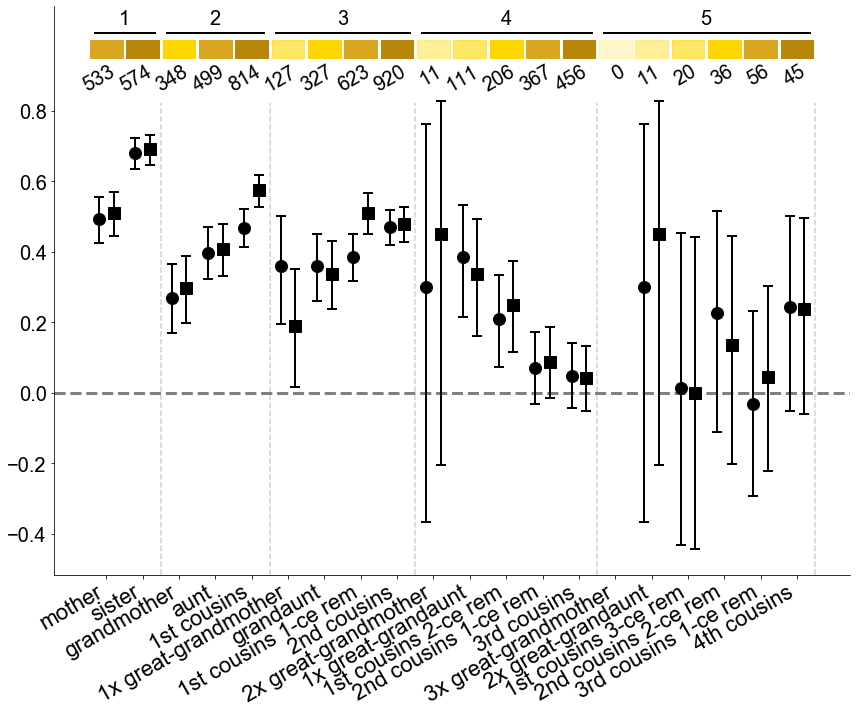

In [38]:
_ = plt.figure(figsize=(12, 10))
plt.errorbar([item - 0.2 for item in range(len(pairs))], pear, 
             yerr=([i - j for i, j in zip(pear, lower_p)], [i - j for i, j in zip(upper_p, pear)]), 
             marker='o', markersize=12, color='black', linewidth=0, ecolor='black', elinewidth=2, capsize=5, capthick=2.0, 
             label="Pearson Correlation Coefficient ± 95% Confidence Interval")
plt.errorbar([item + 0.2 for item in range(len(pairs))], spea, 
             yerr=([i - j for i, j in zip(spea, lower_s)], [i - j for i, j in zip(upper_s, spea)]), 
             marker='s', markersize=12, color='black', linewidth=0, ecolor='black', elinewidth=2, capsize=5, capthick=2.0, 
             label="Spearman Correlation Coefficient ± 95% Confidence Interval")

x1, x2 = -0.45, 0.45
for colour, alpha, pair in zip(colours, alphas, pairs):
    plt.fill_betweenx(y=[0.95, 1.0], x1=x1, x2=x2, color=colour, alpha=alpha, zorder=0)
    plt.text(x=x1+0.78, y=0.94, s=str(pair), horizontalalignment='right', verticalalignment='top', rotation=30, fontname="Arial", fontsize=20)
    x1 += 1.0
    x2 += 1.0

x1, x2 = -0.35, 1.35
for i in range(5):
    plt.fill_betweenx(y=[1.020, 1.023], x1=x1, x2=x2, color="black", alpha=alpha, zorder=0)
    plt.text(x=x1+(x2-x1)/2, y=1.06, s=str(i+1), fontname="Arial", fontsize=20, horizontalalignment='center', verticalalignment='center')
    plt.axvline(x=x2+0.15, ymax=0.83, color="lightgrey", linestyle="dashed", zorder=0)
    x1 += i + 2
    x2 += i + 3

plt.axhline(y=0, color="grey", linestyle="dashed", linewidth=3.0, zorder=0)
plt.xticks(list(range(len(names))), [f"{name}" for name, pair in zip(names, pairs)], horizontalalignment='right', verticalalignment='top', rotation=30, fontname="Arial", fontsize=22)
plt.yticks([item / 10 for item in range(-4, 9, 2)], fontname="Arial", fontsize=20)

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.tight_layout()
plt.show()


### Done!

Remember, when drawing conclusions from this figure, that you need 1000s (if not 10000s) of cell replicates to see patterns & trends in the overall population behaviour. Don't get confused by trends which are drawn from low cell numbers. 